# Comparing K-means or GMM classifier on SAR data to optical WOfS inundation summaries for an example area (Mamukala Wetlands - Kakadu)

In [ ]:
%matplotlib inline
import numpy as np
import datacube
import matplotlib.pyplot as plt
import radar_functions as rf
import radar_gmm as rg
import fiona
from datacube.utils import geometry
import rasterio.features

import xarray as xr

## Initialising the radar datacube and loading the relevant region

In [ ]:
dc = datacube.Datacube(config='radar.conf')

In [ ]:
#define the sample region and train the SAR classifier

#define the time period
qtime = ('2016-09-01', '2018-01-01')

query = {
         'time': qtime,
         'lat' : (-32.53,-32.15),
         'long' : (142.16,142.70),
         }

#load the raw SAR scenes
sardata = dc.load(product='s1_gamma0_scene_v2', group_by='solar_day', output_crs='EPSG:3577',resolution=(25,25), **query)

#Denoise and mask the radar data with the actual polygon - it will have been returned as a rectangle
sardata=sardata.where(sardata!=0)
clean=rf.denoise(sardata)
#mask = rasterio.features.geometry_mask([geom.to_crs(sardata.geobox.crs)for geoms in [geom]],
#                                           out_shape=sardata.geobox.shape,
#                                           transform=sardata.geobox.affine,
#                                           all_touched=False,
#                                           invert=False)
#clean=clean.where(~mask)

#drop scenes with a lot of NaN pixels
nanmask = ((np.isnan(clean).mean(dim = ['x','y'])) > 0.2).vv
valtimes = nanmask.where(~nanmask).dropna(dim='time')['time']

clean = clean.sel(time = valtimes)

#Take the natural logarithm of the backscatter to improve differentiation of dark areas
logclean = np.log(clean)

## Fit and demonstrate the model

In [33]:
#fit the GMM and K-means clustering models (on one time slice)
gmm = rg.fit_gmm(logclean.isel(time=10),n_components=4)
kmm = rg.fit_kmeans(logclean.isel(time=10),n_components=4)

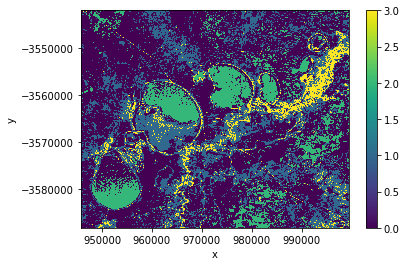

In [34]:
#plot the k-means predictions for a time slice (helps to figure out exactly which class was assigned for 'water')
#the class which ends up as 'water' from the classifier will vary between initialisations
rg.plot_gmm_classes(logclean.isel(time=30),kmm)

This menindee lakes area has some trouble with confusion between bare soil and water, as well as calibration issues in the northwest corner of the scenes where another pass is stitched into the image, with correspondingly different look angles etc affecting the SAR signal

In [35]:
#predict on all the radar data
kmm_ds = rg.gmm_dataset(logclean,kmm)

## 'Open water' classification demo - compare with WOfS

In [36]:
#produce an 'is water' dataset and compute a 'WOfS summary' version of this (which we can plot with the WOfS plotting tools)
openw_ds = (kmm_ds == 2)

SARsummary = openw_ds.sum(dim='time',keep_attrs=True)/len(openw_ds)

#The sortby ensures that the image is the right way up when plotting as for some reason the WOfS plotter tool does not preserve the spatial coordinates
SARsummary = SARsummary.sortby('y',ascending=False)

In [37]:
# Import external functions from dea-notebooks
import sys
sys.path.append('./10_Scripts/')
import DEAPlotting

In [38]:
#optical datacube - the radar one is separate and does not duplicate the Landsat archive
dcO = datacube.Datacube()

xarray dataset has no spatial data; defaulting to plotting without coordinates. This can often be resolved by adding `keep_attrs = True` during an aggregation step
xarray dataset has no spatial data; defaulting to plotting without coordinates. This can often be resolved by adding `keep_attrs = True` during an aggregation step


(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff922d2e5f8>)

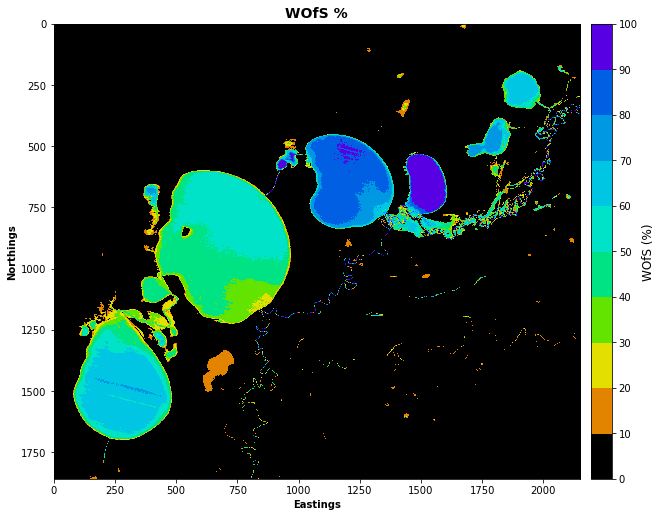

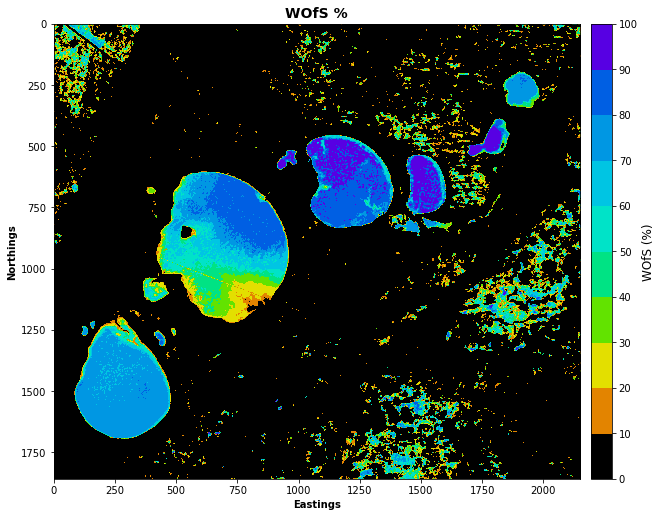

In [39]:
from digitalearthau.utils import wofs_fuser
#for some reason the filtered summary only exists in 2018 so we need to change the query here. This means the WOfS *summary* (not the WOFLs) are not
#necessarily directly comparable but should give us an OK idea of what the SAR summary should look like.
qtime = ('2016-09-01', '2019-06-01')

query = {
    'lat' : (-32.53,-32.15),
    'long' : (142.16,142.70),
    'time' : qtime
}

wofs_filtered_summary = dcO.load(product = 'wofs_filtered_summary',fuse_func=wofs_fuser, **query)

DEAPlotting.plot_WOfS(wofs_filtered_summary.wofs_filtered_summary.isel(time=0)*100)

DEAPlotting.plot_WOfS(SARsummary*100)

The SAR summary is broadly similar to the WOfS one, but it tends to overestimate the lakes' inundation frequency by 5-10% and the bare-soil false positives are apparent. The SAR also misses smaller waterbodies and rivers - this is likely due to the smaller intrinsic spatial resolution of the SAR sensor (even if the pixel resolution is the same), as well as the fact that rivers and their floodplains actually seem to fall into their own class in the K-means classifier in this region (this is clearly evident on the classification plot further up).

## Timeseries comparison - how good is SAR at measuring changes in inundation extent over time?

First calculate the timeseries of the fraction of pixels falling into each K-means class in the SAR images

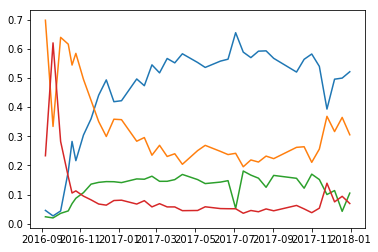

In [40]:
#multiprocessing routine to speed up the timeseries calculation
import multiprocessing as mp

pool = mp.Pool(mp.cpu_count())

index_stops = np.linspace(0,len(clean.time),num=mp.cpu_count()+1,dtype=int)

results = [pool.apply_async(rg.calc_gmm_timeseries,args=(np.log(clean),kmm),kwds={'tmin':index_stops[i],'tmax':index_stops[i+1]}) for i in range(len(index_stops) - 1)]

pool.close()
pool.join()

res_a = [r.get() for r in results]

t = xr.concat([res[0] for res in res_a],dim='time')
ts = np.concatenate(tuple(res[1] for res in res_a))

plt.plot(t,ts)

Then load the WOfS feature layers to calculate a similar 'inundated pixel fraction' for the optical classifiers, making sure to discard heavily cloudmasked images

In [41]:
#change the query back to the correct time range for the WOFLs
qtime = ('2016-09-01', '2018-01-01')

query = {
         'time': qtime,
         'lat' : (-32.53,-32.15),
         'long' : (142.16,142.70),
         }

wofls_ts = dcO.load(product = 'wofs_albers', **query)

In [42]:
from datacube.storage import masking
wofls_wet_mask = masking.make_mask(wofls_ts,wet=True)
wofls_dry_mask = masking.make_mask(wofls_ts,dry=True)
wofls_valid_mask = wofls_wet_mask | wofls_dry_mask
#at least 70% cloud-free
wofls_vfrac = wofls_valid_mask.mean(dim=['x','y'])
valid_times = wofls_vfrac.where(wofls_vfrac > 0.7).dropna(dim='time')['time']



wofls_wpercent_ts = wofls_wet_mask.sel(time=valid_times).mean(dim=['x','y'])/wofls_valid_mask.sel(time=valid_times).mean(dim=['x','y'])

Make everything into a nice figure to see how the two timeseries track each other

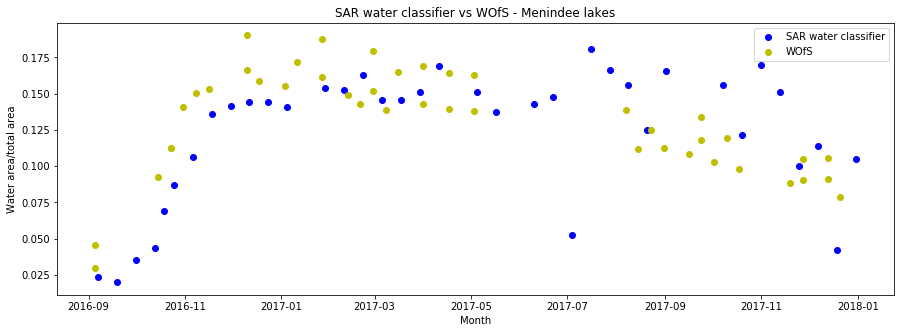

In [43]:
fig,ax = plt.subplots(1,1,figsize=(15,5))
#make sure you use the right class in the ts array in this line!
plt.plot(t,ts[:,2],'bo',label='SAR water classifier')
plt.plot(wofls_wpercent_ts['time'],wofls_wpercent_ts['water'],'yo',label='WOfS')
plt.xlabel('Month')
plt.ylabel('Water area/total area')
plt.title('SAR water classifier vs WOfS - Menindee lakes')
plt.legend()
plt.show()

Prediction is pretty good at the start, tracking pretty closely - the slight negative offset is possibly due to the SAR not picking up rivers and smaller ponds as 'open' water. Towards the end the SAR continues tracking the broad trend of the optical observations, but becomes much less reliable scene-to-scene. This is possibly a result of the region drying out, leading to more bare soil which is not differentiated from open water. There are also two outliers below the WOfS trend,  which we will now investigate further by plotting the class predictions for these scenes individually.

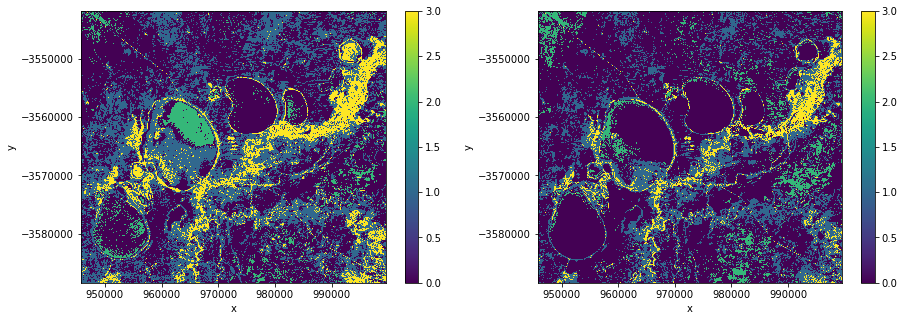

In [45]:
fig,ax=plt.subplots(1,2,figsize=[15,5])
rg.plot_gmm_classes(logclean.isel(time=-2),kmm,ax=ax[0])
rg.plot_gmm_classes(logclean.isel(time=-14),kmm,ax=ax[1])

It is clear from these images that part of the (full) Lakes Pamamaroo and Tandure, along with the partially-filled Lakes Menindee and Cawndilla, are being misidentified as dry land. This further reinforces the conclusion that bare soil differentiation against open water with SAR is imperfect. The fact that all of the major lakes exhibit this issue in these scenes suggests a calibration issue in the processing of these images.

## Month-by-month composite comparison of WOfS and SAR classifier

This is useful for a visual comparison of WOfS and SAR classifier over time

In [46]:
#put all the nasty loading and filtering code for the SAR scenes in a simple-to-use function.

def load_cleaned_SAR(query):

    #load the raw SAR scenes
    sardata = dc.load(product='s1_gamma0_scene_v2', group_by='solar_day', output_crs='EPSG:3577',resolution=(25,25), **query)

    #Denoise and mask the radar data with the actual polygon - it will have been returned as a rectangle
    sardata=sardata.where(sardata!=0)
    clean=rf.denoise(sardata)
    #mask = rasterio.features.geometry_mask([geom.to_crs(sardata.geobox.crs)for geoms in [geom]],
    #                                           out_shape=sardata.geobox.shape,
    #                                           transform=sardata.geobox.affine,
    #                                           all_touched=False,
    #                                           invert=False)
    #clean=clean.where(~mask)

    #drop scenes with a lot of NaN pixels
    nanmask = ((np.isnan(clean).mean(dim = ['x','y'])) > 0.2).vv
    valtimes = nanmask.where(~nanmask).dropna(dim='time')['time']

    clean = clean.sel(time = valtimes)
    
    return clean

In [47]:
#dodgy monthly composites

from datacube.storage import masking

def wofls_composite(wofls_ts):
    wofls_wet_mask = masking.make_mask(wofls_ts,wet=True)
    wofls_dry_mask = masking.make_mask(wofls_ts,dry=True)
    wofls_valid_mask = (wofls_wet_mask | wofls_dry_mask).any(dim='time')
    
    compo = wofls_wet_mask.any(dim='time').where(wofls_valid_mask)
    return compo.water

def SAR_composite(SAR_ds):
    return SAR_ds.mean(dim='time')
    

In [48]:
import gc

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops

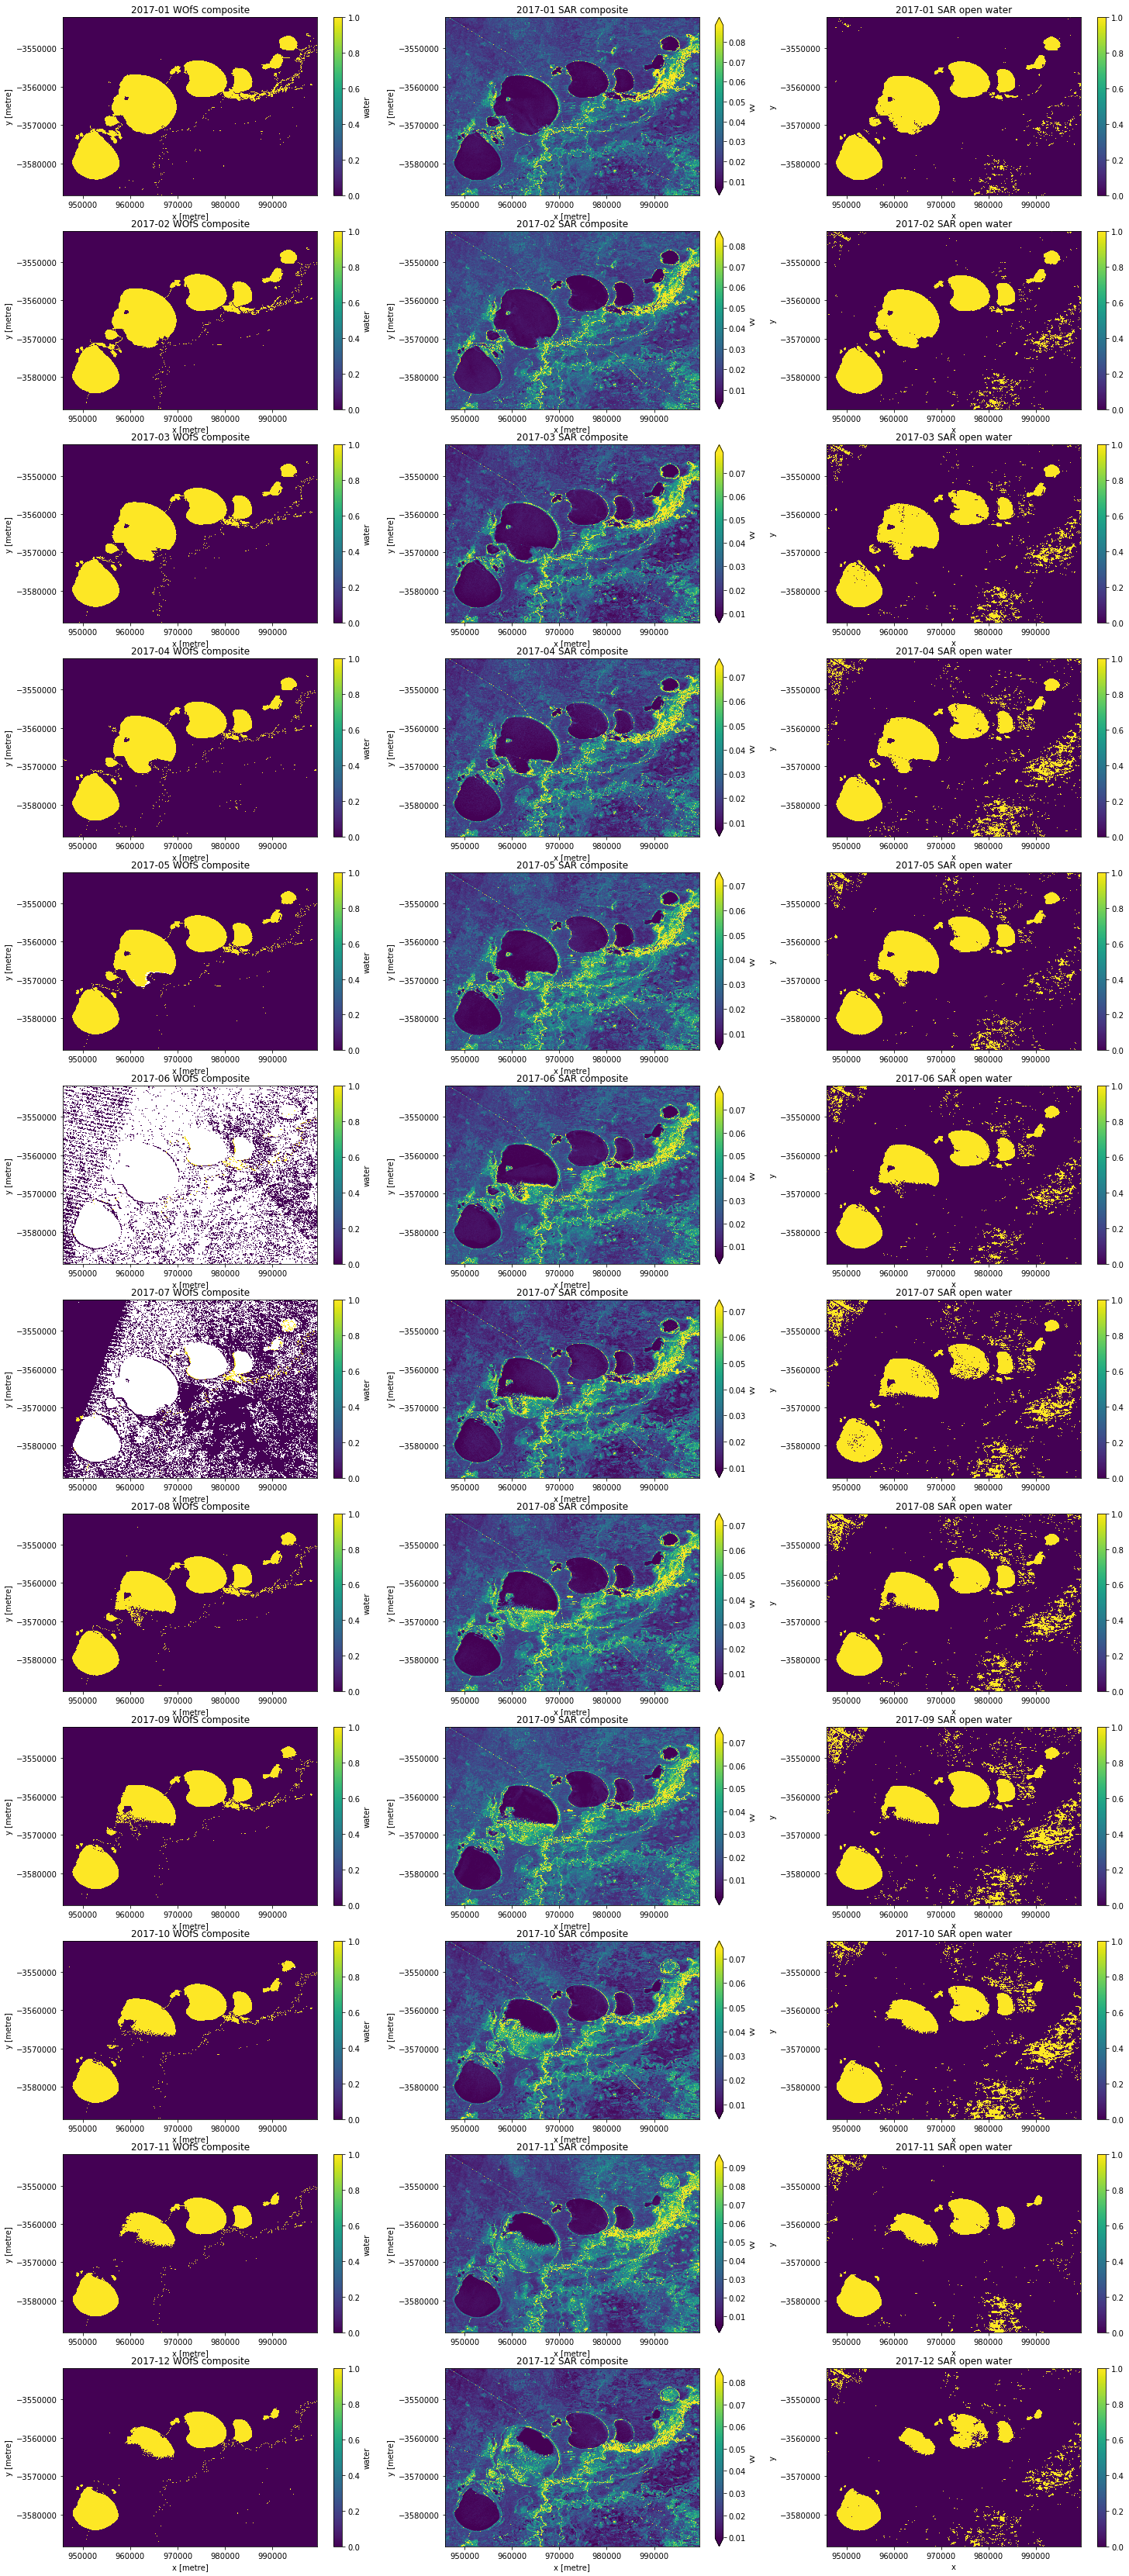

In [50]:
#make sure these values are correct if you want to study a different region

lat = (-32.53,-32.15)
long = (142.16,142.70)


fig,ax = plt.subplots(12,3,figsize=(25,60))

for month in range(1,13):
    first = '2017-'+'{:02d}'.format(month)+'-01'
    last = str(2017+month//12)+'-'+'{:02d}'.format(month%12+1)+'-01'

    query = {
        'lat': lat,
        'long': long,
        'time': (first,last)
    }
    
    
    wofls_ds = dcO.load(product = 'wofs_albers', **query)
    
    if len(wofls_ds.water)>0:
        comp = wofls_composite(wofls_ds)
        if comp is not None:
            comp.plot(ax=ax[month-1,0])
            ax[month-1,0].title.set_text(first[:-3]+' WOfS composite')    
    #calls to gc and del help with avoiding OOM errors
    del(wofls_ds)
    
    sar_ds = load_cleaned_SAR(query)
    
    compSAR = SAR_composite(sar_ds)
    
    del(sar_ds)
    
    compSAR.vv.plot(ax=ax[month-1,1],robust=True)
    ax[month-1,1].title.set_text(first[:-3]+' SAR composite')
    
    plt.sca(ax[month-1,2])
    
    kmm_ds = rg.calc_gmm_classes(np.log(compSAR),kmm)
    #this line should change depending on the index of the 'open water' class!
    (kmm_ds == 2).plot()
    ax[month-1,2].title.set_text(first[:-3]+' SAR open water')
            
    
    gc.collect()


## Tracking inundation changes over time and through clouds with SAR

The SAR classifier in its current state could be used to at least track inundation changes on a monthly/seasonal basis using composite images, which are somewhat less susceptible to misclassification of dry land as water or vice versa. The following cells demonstrate an example of this type of tracking. This tracking will probably be more useful for regions with stronger seasonal variation in rainfall like tropical wetlands in Kakadu

In [60]:
#do the monthly timeseries thing
from collections import OrderedDict

lat = (-32.53,-32.15)
long = (142.16,142.70)

wofs_mean_ts = np.array([])
sar_mean_ts = np.array([])


for month in range(1,13):
    first = '2017-'+'{:02d}'.format(month)+'-01'
    last = str(2017+month//12)+'-'+'{:02d}'.format(month%12+1)+'-01'

    query = {
        'lat': lat,
        'long': long,
        'time': (first,last)
    }
    
    
    
    wofls_ds = dcO.load(product = 'wofs_albers', **query)
    
    if len(wofls_ds.water)>0:
        compmean = wofls_composite(wofls_ds).mean(dim=['x','y']).expand_dims('time')
        compmean['time'] = [np.datetime64(first)]
        if wofs_mean_ts.any():
            wofs_mean_ts = xr.concat([wofs_mean_ts,compmean],dim='time')
        else:
            wofs_mean_ts = compmean
            
        
        
        
    #calls to gc and del help with avoiding OOM errors
    del(wofls_ds)
    
    sar_ds = load_cleaned_SAR(query)
    
    compSAR = SAR_composite(sar_ds)
    
    del(sar_ds)
    
    
    kmm_ds = rg.calc_gmm_classes(np.log(compSAR),kmm)
    sarmean = (kmm_ds == 2).mean(dim=['x','y']).expand_dims('time')
    sarmean['time'] = [np.datetime64(first)]
    if sar_mean_ts.any():
        sar_mean_ts = xr.concat([sar_mean_ts,sarmean],dim='time')
    else:
        sar_mean_ts = sarmean
    
    
    
    del(compSAR)
            
    
    gc.collect()


/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops

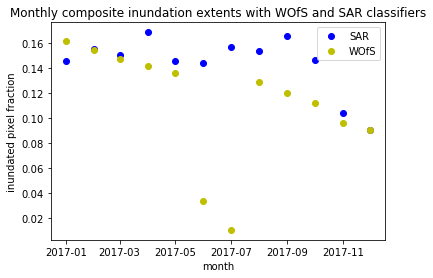

In [61]:
plt.plot(sar_mean_ts['time'],sar_mean_ts,'bo',label='SAR')
plt.plot(wofs_mean_ts['time'],wofs_mean_ts,'yo',label='WOfS')
plt.xlabel('month')
plt.ylabel('inundated pixel fraction')
plt.title('Monthly composite inundation extents with WOfS and SAR classifiers')
plt.legend()

In [63]:
wofs_mean_ts[-1]

<xarray.DataArray 'water' ()>
array(0.090827)
Coordinates:
    time     datetime64[ns] 2017-12-01